# Time Series Clustering with K-Means and Euclidean Distance Matrix for total (n2)


This notebook provides a base clustering for ordinary and scripted trips together without feature engineering and K-Means with k=3. k=3 follows the naive assumption that the cluster structure is only influenced by the labels. 

We found that there are the following problems with this base line approach:
- Mode "METRO" and "TRAM" are not clustered distinctly
- Mode "WALK" has too many clusters
- We have to cut more than 30 seconds from the scripted trips during preprocessing

In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels

%aimport models.cluster
from models.cluster import get_clustering_performance

In [2]:
data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
#file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")

dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)



In [3]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]
euclidean_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="euclidean")
correlation_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="correlation")
#file_path = os.path.join(data_dir, "preprocessed","449_train_loss_0.0771002_encodings.csv")
#encoded_distances = pd.read_csv(file_path, sep=";", index_col=False).drop(["Unnamed: 0"],axis=1)

## Summary Statistics of euclidean distances:

In [4]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_only = euclidean_distances.drop(categorical_columns,axis=1)
#print(trips_only.shape)
#trips_only.head(5)

In [5]:
percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
summaries_euclidean = trips_only.transpose().describe(percentiles=percentiles).T
summaries_euclidean = summaries_euclidean.drop(["count","min","max","mean"],axis=1)
summaries_euclidean.head()

std       10%        20%        30%        40%        50%        60%  \
0  46.312626  5.113999  10.969244  13.968302  16.010608  17.779187  25.886894   
1  46.317107  6.524236   9.860011  12.714856  14.415152  16.115815  24.488955   
2  46.522843  5.106156   9.913497  12.802564  14.708427  16.442876  24.843179   
3  46.713160  6.131170   7.954911  10.858895  12.634375  14.406362  23.573733   
4  46.471581  7.055660   8.650629  10.985250  12.719227  14.582598  23.344431   

         70%         80%         90%  
0  74.477420  103.926217  117.421241  
1  73.606425  103.215259  116.645468  
2  73.791944  103.536724  117.141415  
3  73.051550  102.683259  116.413055  
4  73.099861  102.772248  116.260641

## Summary Statistics of correlation distances:

In [6]:
summaries_corr = correlation_distances.drop(categorical_columns,axis=1).transpose().describe(percentiles=percentiles).T
summaries_corr = summaries_corr.drop(["count","min","max","mean"],axis=1)
summaries_corr.head()

std       10%       20%       30%       40%       50%       60%  \
0  0.138578  0.853371  0.936044  0.972948  0.990810  1.005372  1.018564   
1  0.087753  0.900542  0.939666  0.963225  0.983047  0.999400  1.014736   
2  0.095643  0.902212  0.939226  0.966594  0.983479  1.000549  1.022224   
3  0.157529  0.827348  0.918702  0.961199  0.983728  1.002321  1.023646   
4  0.076903  0.916551  0.948485  0.969157  0.987173  1.001178  1.016017   

        70%       80%       90%  
0  1.039240  1.077143  1.135203  
1  1.030039  1.056031  1.097234  
2  1.041496  1.065596  1.109155  
3  1.046868  1.086955  1.169657  
4  1.030664  1.050832  1.087909

## Use Correlation distance and euclidean distance summary features together

In [7]:
summaries = deepcopy(summaries_euclidean)
for name in summaries_euclidean.columns:
    summaries["cor_"+name] = summaries_corr[name]

summaries.head()

std       10%        20%        30%        40%        50%        60%  \
0  46.312626  5.113999  10.969244  13.968302  16.010608  17.779187  25.886894   
1  46.317107  6.524236   9.860011  12.714856  14.415152  16.115815  24.488955   
2  46.522843  5.106156   9.913497  12.802564  14.708427  16.442876  24.843179   
3  46.713160  6.131170   7.954911  10.858895  12.634375  14.406362  23.573733   
4  46.471581  7.055660   8.650629  10.985250  12.719227  14.582598  23.344431   

         70%         80%         90%   cor_std   cor_10%   cor_20%   cor_30%  \
0  74.477420  103.926217  117.421241  0.138578  0.853371  0.936044  0.972948   
1  73.606425  103.215259  116.645468  0.087753  0.900542  0.939666  0.963225   
2  73.791944  103.536724  117.141415  0.095643  0.902212  0.939226  0.966594   
3  73.051550  102.683259  116.413055  0.157529  0.827348  0.918702  0.961199   
4  73.099861  102.772248  116.260641  0.076903  0.916551  0.948485  0.969157   

    cor_40%   cor_50%   cor_60%   cor_70%   cor_80%   cor_90%  
0  0.990810  1.005372  1.018564  1.039240  1.077143  1.135203  
1  0.983047  0.999400  1.014736  1.030039  1.056031  1.097234  
2  0.983479  1.000549  1.022224  1.041496  1.065596  1.109155  
3  0.983728  1.002321  1.023646  1.046868  1.086955  1.169657  
4  0.987173  1.001178  1.016017  1.030664  1.050832  1.087909

In [8]:
from sklearn.preprocessing import scale

summaries_scaled = pd.DataFrame(scale(summaries),columns=summaries.columns)
summaries_scaled.head()

std       10%       20%       30%       40%       50%       60%  \
0  0.795250 -0.754519 -0.673764 -0.644978 -0.653911 -0.696482 -0.688749   
1  0.795646 -0.724787 -0.697561 -0.672193 -0.689267 -0.734172 -0.722608   
2  0.813788 -0.754685 -0.696413 -0.670288 -0.682768 -0.726761 -0.714028   
3  0.830571 -0.733074 -0.738433 -0.712490 -0.728731 -0.772906 -0.744775   
4  0.809268 -0.713582 -0.723507 -0.709746 -0.726850 -0.768912 -0.750328   

        70%       80%       90%   cor_std   cor_10%   cor_20%   cor_30%  \
0 -0.567527 -0.551522 -0.553332  2.626207 -2.227591 -1.758242 -0.878243   
1 -0.599995 -0.584962 -0.591134  0.458636 -0.641827 -1.482576 -2.296077   
2 -0.593080 -0.569842 -0.566968  0.795149 -0.585663 -1.516064 -1.804828   
3 -0.620680 -0.609985 -0.602460  3.434414 -3.102426 -3.078176 -2.591489   
4 -0.618879 -0.605799 -0.609886 -0.004085 -0.103641 -0.811369 -1.431104   

    cor_40%   cor_50%   cor_60%   cor_70%   cor_80%   cor_90%  
0 -0.030279  3.178245  2.305826  2.407668  2.713184  1.932450  
1 -2.259845 -0.600956  1.299518  1.137756  1.105295  0.603897  
2 -2.135898  0.126741  3.267873  2.718970  1.833771  1.021024  
3 -2.064319  1.247751  3.641876  3.460340  3.460494  3.138016  
4 -1.074911  0.524475  1.636231  1.224058  0.709386  0.277604

## Apply PCA to euclidean distances and to summaries

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
trips_reduced = pd.DataFrame(pca.fit_transform(trips_only))

pca_2 = PCA(n_components=10)
summaries_reduced = pd.DataFrame(pca_2.fit_transform(summaries_scaled))
#trips_reduced.head()

------
## Create Base Model with Euclidean Distance and KMeans Clustering

Use summaries of each distance

In [26]:
#from sklearn.cluster import DBSCAN
#random_state = 0
#features_used = encoded_distances.drop(categorical_columns,axis=1)
#db = DBSCAN(eps=0.7, min_samples=5).fit(features_used)

#cluster_labels = db.labels_
#print("unique cluster labels: ", set(cluster_labels))
#euclidean_distances["cluster_labels"]=cluster_labels


In [27]:
from sklearn.cluster import KMeans
random_state = 0
features_used = summaries_scaled
#Naive asumption of 3 clusters due to 3 labels Walk, Metro and Tram 
kmeans = KMeans(n_clusters=3, random_state=random_state).fit(features_used)
cluster_labels = kmeans.labels_
euclidean_distances["cluster_labels"]=cluster_labels

### Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [28]:
# how well does it capture the label information
get_clustering_performance(features_used, cluster_labels,
                           true_labels=euclidean_distances["mode"])

['Estimated number of clusters: 3',
 'True number of clusters: 3',
 'Homogeneity: 0.356',
 'Completeness: 0.360',
 'V-measure: 0.358',
 'Adjusted MI: 0.355',
 'Silhouette Coefficient: 0.329']

In [29]:
# Uncomment if you want to explore full dataframe
#with pd.option_context('display.max_rows', None):
#    display(scripted_trips[scripted_trips["scripted"]==0])

## Visualise clustering result for one specific trip

Select one trip:

In [30]:
selected_trip = 51
small_df_trip = euclidean_distances[euclidean_distances.trip_id == selected_trip]
small_df_trip.head()

distance_0  distance_1  distance_2  distance_3  distance_4  distance_5  \
1162   84.735235   84.344483   84.333433   83.610749   84.093996   83.917748   
1163  113.325428  112.833079  112.733547  111.804102  111.939612  112.040739   
1164  135.189048  134.565304  134.767175  133.752800  133.726632  133.904268   
1165  155.905344  154.774718  155.410664  154.362197  153.943094  154.444439   
1166  144.991956  144.048439  144.488508  143.643959  143.667168  143.670999   

      distance_6  distance_7  distance_8  distance_9       ...        \
1162   83.143163   83.599680   83.382293   82.948666       ...         
1163  110.764570  111.271460  111.296403  111.052209       ...         
1164  132.722996  133.073361  133.051532  132.799229       ...         
1165  153.152143  153.703242  153.563131  153.001944       ...         
1166  142.753349  142.944702  142.956290  142.757307       ...         

      distance_1587  distance_1588  distance_1589  distance_1590  mode  \
1162      82.516819      83.473504      83.039636      89.628642  WALK   
1163     109.786282     110.681327     109.768691     113.041201  WALK   
1164     131.482536     131.446549     131.712451     133.525776  WALK   
1165     151.533694     152.122149     151.284158     156.495037  WALK   
1166     141.731611     142.020623     141.090958     145.407665  WALK   

                     notes  scripted            token  trip_id  cluster_labels  
1162  ordinary hoferanduni         0  868049020858898       51               0  
1163  ordinary hoferanduni         0  868049020858898       51               0  
1164  ordinary hoferanduni         0  868049020858898       51               0  
1165  ordinary hoferanduni         0  868049020858898       51               0  
1166  ordinary hoferanduni         0  868049020858898       51               0  

[5 rows x 1597 columns]

First, make sure that cut trips and original trips are the same by checking the first values in the total column

In [31]:
trips_cut_per_30_sec[trips_cut_per_30_sec.trip_id == selected_trip].head(1)

snippet_0 snippet_1 snippet_2 snippet_3 snippet_4 snippet_5 snippet_6  \
1162   8.69345   8.81153   8.86198   8.49275   8.23892   8.63844   7.91614   

     snippet_7 snippet_8 snippet_9   ...   snippet_595 snippet_596  \
1162   9.99795   10.8403    12.432   ...       10.8277     8.62898   

     snippet_597 snippet_598 snippet_599  mode                 notes scripted  \
1162     5.54272     3.62859     4.31096  WALK  ordinary hoferanduni        0   

                token trip_id  
1162  868049020858898      51  

[1 rows x 605 columns]

In [32]:
trips_unpacked = Preprocessor.unpack_all_trips(dfs)
acceleration_data_trip = trips_unpacked[selected_trip]["sensor"]
acceleration_data_trip = deepcopy(acceleration_data_trip[acceleration_data_trip.sensor == "acceleration"])
# Important, because indices are not unique
acceleration_data_trip = acceleration_data_trip.reset_index(drop=True)

acceleration_data_trip.head()

time     total         x         y         z  \
0 2017-12-06 11:46:29.815  8.693447 -0.548078  1.629004  8.521853   
1 2017-12-06 11:46:29.860  8.811531  0.131337  1.341359  8.707846   
2 2017-12-06 11:46:29.910  8.861978  0.446902  1.679908  8.689813   
3 2017-12-06 11:46:29.960  8.492753  0.406448  1.917852  8.263383   
4 2017-12-06 11:46:30.010  8.238921  0.170085  2.056487  7.976325   

         sensor  
0  acceleration  
1  acceleration  
2  acceleration  
3  acceleration  
4  acceleration

During the cutting process the last segments which are less than 30 seconds are dropped, thats why we have to drop them in the original dataframe as well:

In [33]:
labels = get_cluster_labels(small_df_trip["cluster_labels"])
diff = acceleration_data_trip.shape[0] - len(labels)
rows_to_be_dropped = acceleration_data_trip.tail(diff).index
acceleration_data_trip = acceleration_data_trip.drop(rows_to_be_dropped)
acceleration_data_trip["cluster_labels"]= labels
acceleration_data_trip.head()

time     total         x         y         z  \
0 2017-12-06 11:46:29.815  8.693447 -0.548078  1.629004  8.521853   
1 2017-12-06 11:46:29.860  8.811531  0.131337  1.341359  8.707846   
2 2017-12-06 11:46:29.910  8.861978  0.446902  1.679908  8.689813   
3 2017-12-06 11:46:29.960  8.492753  0.406448  1.917852  8.263383   
4 2017-12-06 11:46:30.010  8.238921  0.170085  2.056487  7.976325   

         sensor  cluster_labels  
0  acceleration               0  
1  acceleration               0  
2  acceleration               0  
3  acceleration               0  
4  acceleration               0

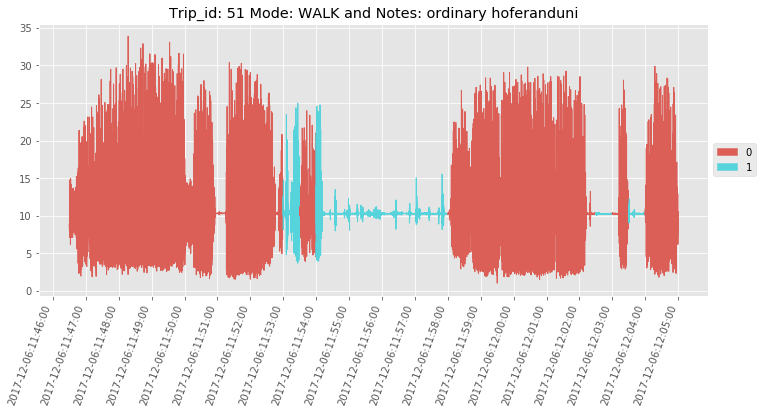

In [34]:
mode = trips_unpacked[selected_trip]["annotation"]["mode"][0]
notes = trips_unpacked[selected_trip]["annotation"]["notes"][0]

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Trip_id: {} Mode: {} and Notes: {}".format(selected_trip, mode,notes))
plot_timeseries_clustering(acceleration_data_trip["time"],acceleration_data_trip["total"], acceleration_data_trip["cluster_labels"], ax=ax)

## Plot the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [35]:
def get_distribution_of_cluster_labels_for(target, distance_matrix):
    column_names = ["count_cluster_"+str(i) for i in np.sort(distance_matrix["cluster_labels"].unique())]
    column_names += [target]
    dist_df = pd.DataFrame(columns=column_names)
    # Collect cluster counts per mode
    for index, target_value in enumerate(distance_matrix[target].unique()):
        distance_per_target_value = distance_matrix[distance_matrix[target]==target_value]
        dist_df.loc[index,target]=target_value
        cluster_label_dist = distance_per_target_value.groupby("cluster_labels").count()[target]
        for cluster_id, label_count in cluster_label_dist.iteritems():
                dist_df.loc[index,"count_cluster_"+str(cluster_id)]=label_count

        dist_df.fillna(0,inplace=True)

    return dist_df

mode_dist_df = get_distribution_of_cluster_labels_for("mode", euclidean_distances)
mode_dist_df

count_cluster_0  count_cluster_1  count_cluster_2   mode
0              1.0            175.0            240.0  METRO
1            475.0            130.0             39.0   WALK
2              1.0            236.0            294.0   TRAM

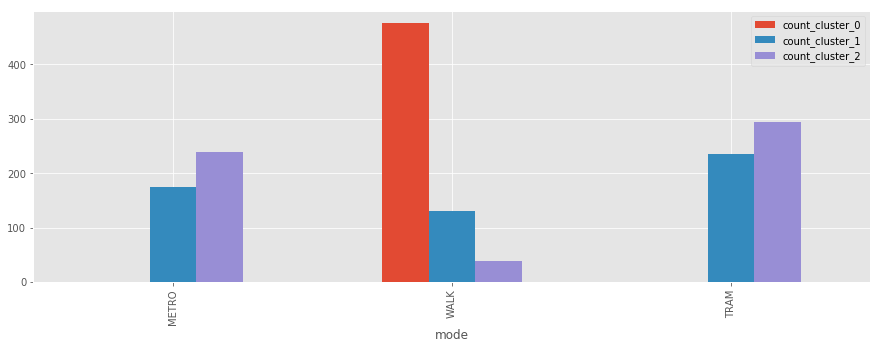

In [36]:
mode_dist_df.set_index("mode").plot(kind="bar",figsize=(15,5));

## Plot distribution of cluster labels for scripted and tokens

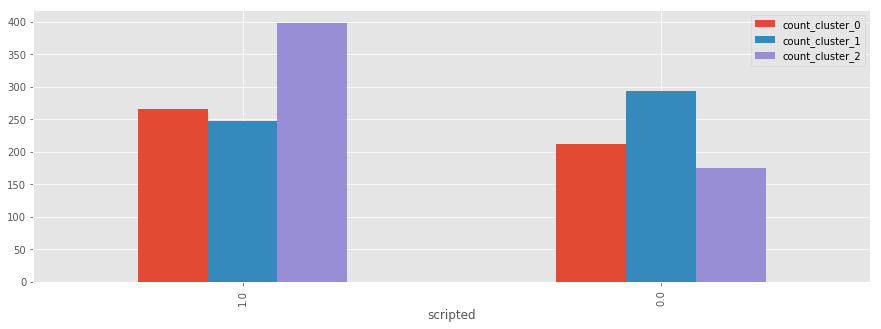

In [37]:
scripted_dist_df = get_distribution_of_cluster_labels_for("scripted", euclidean_distances)
scripted_dist_df.set_index("scripted").plot(kind="bar",figsize=(15,5));

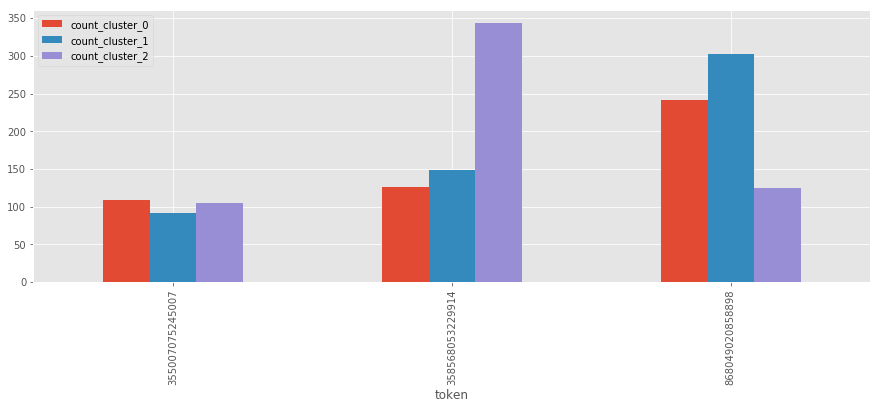

In [38]:
token_dist_df = get_distribution_of_cluster_labels_for("token", euclidean_distances)
token_dist_df.set_index("token").plot(kind="bar",figsize=(15,5));

## Plot all trips with their clustering labels

Produce this plot more conveniently by writing:

C:\Users\Lukas\.conda\envs\Tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



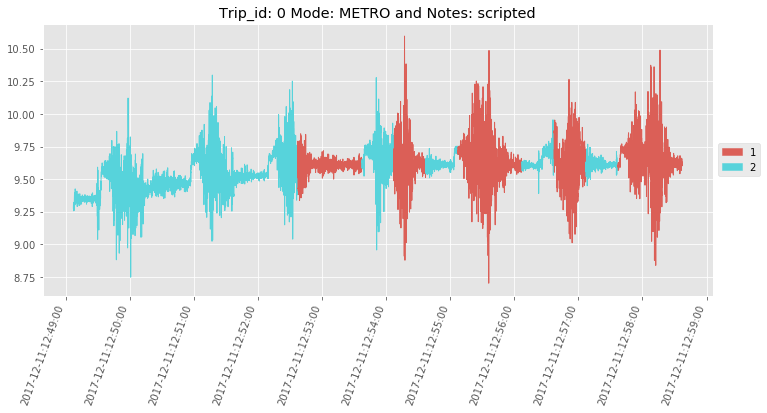

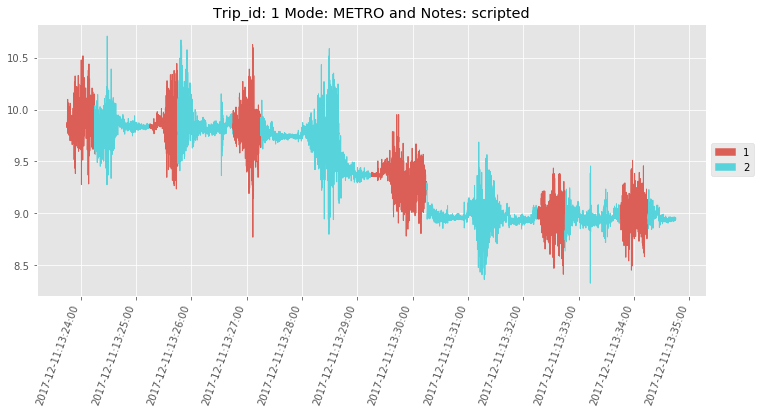

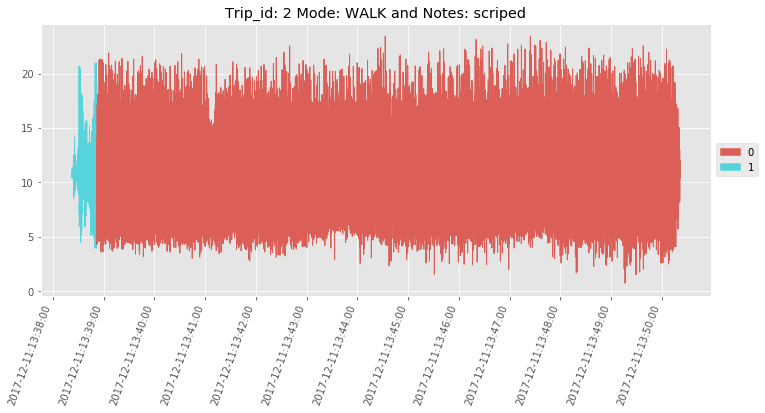

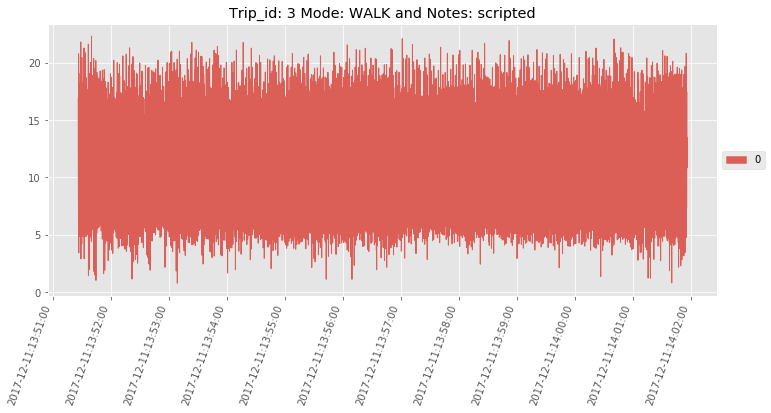

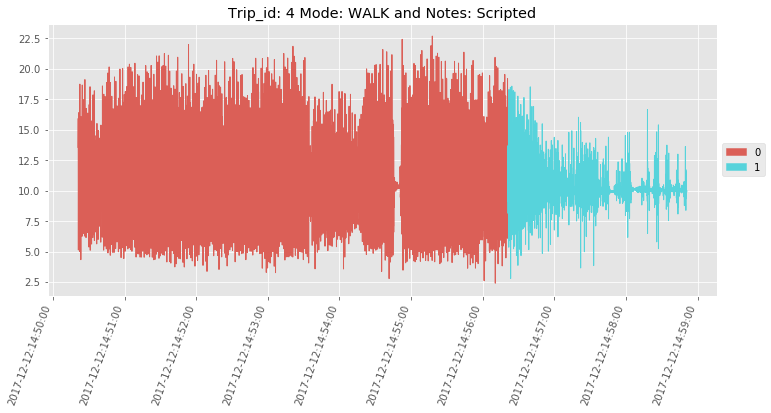

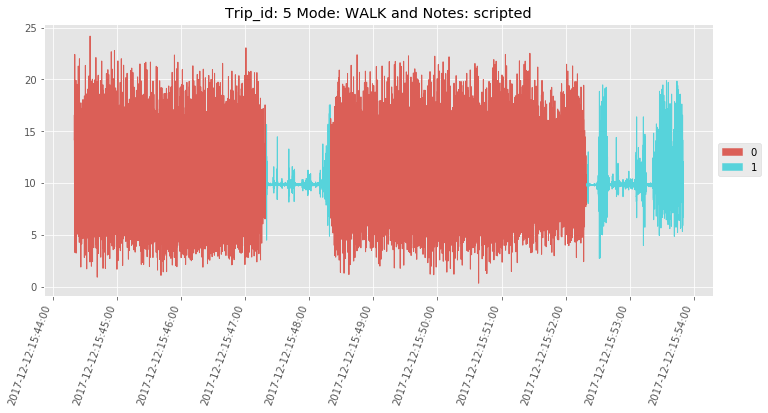

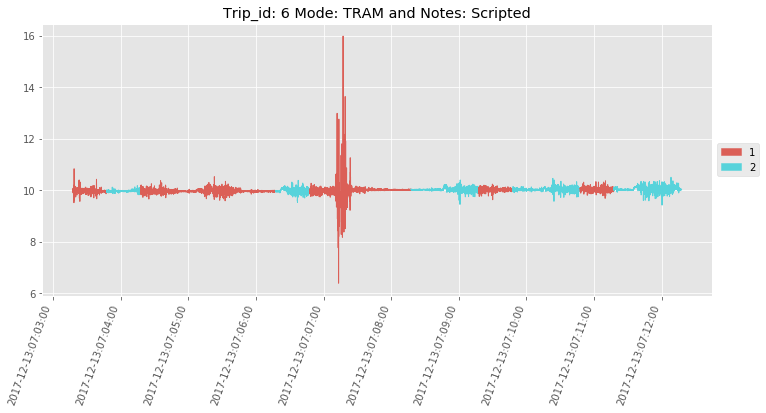

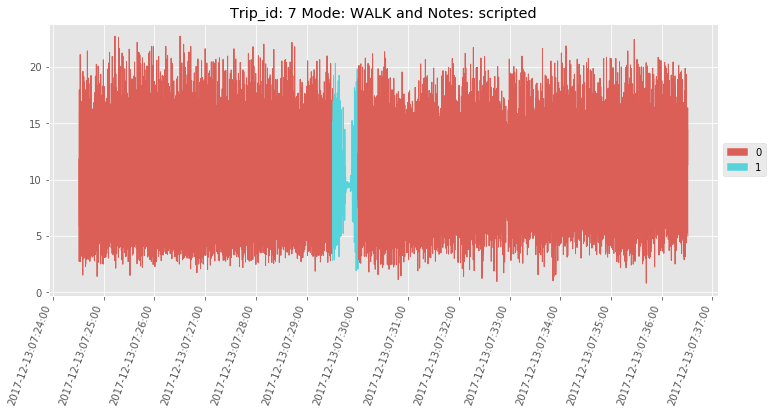

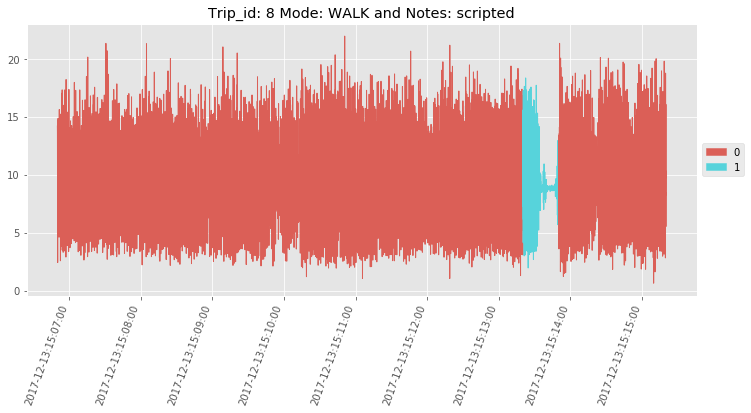

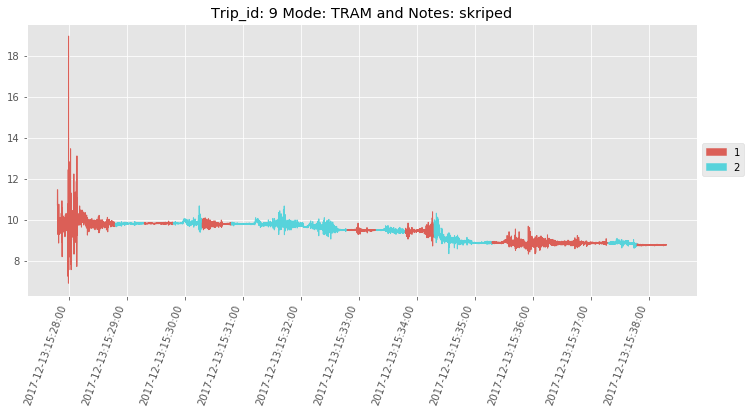

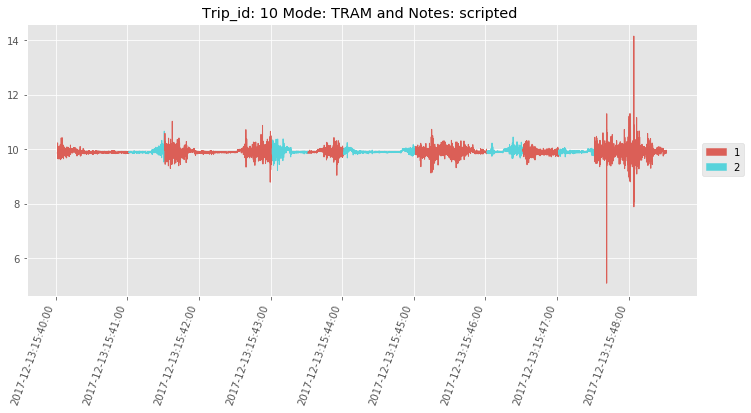

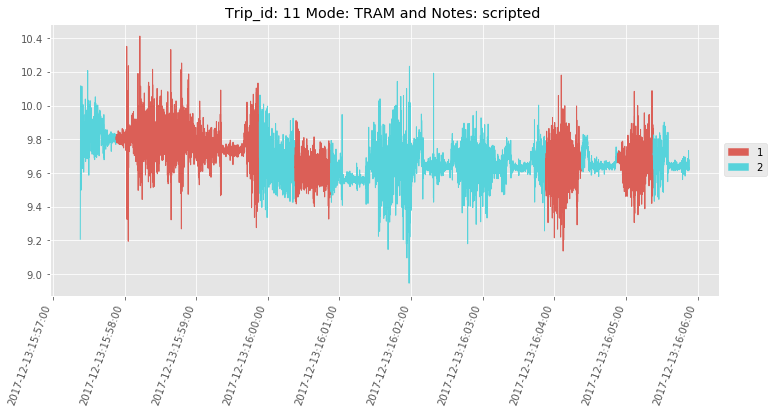

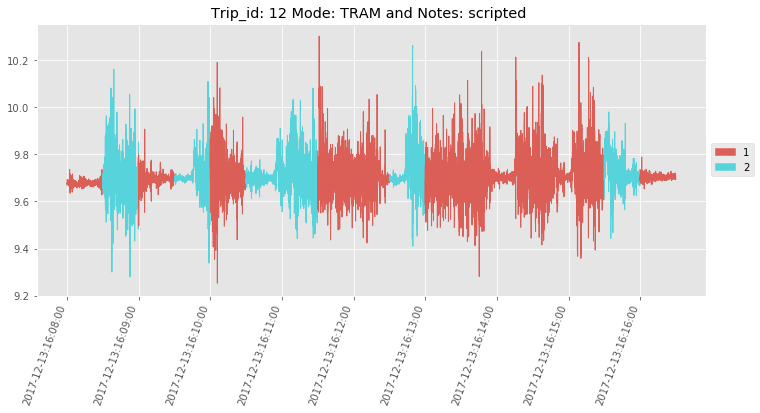

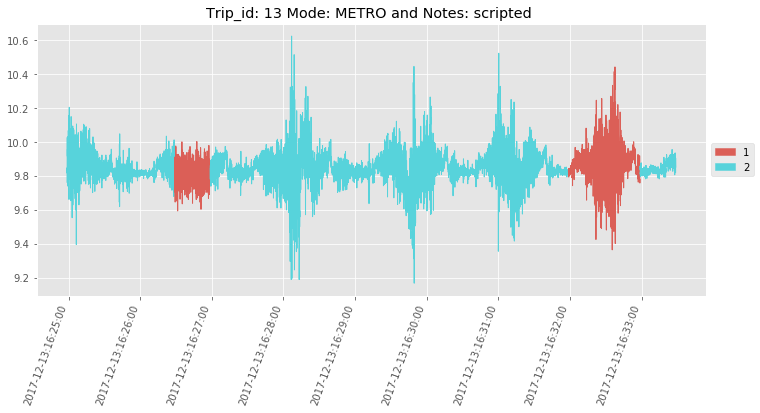

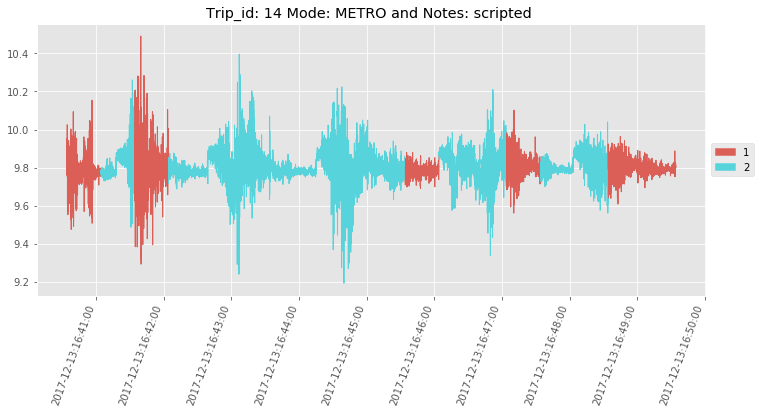

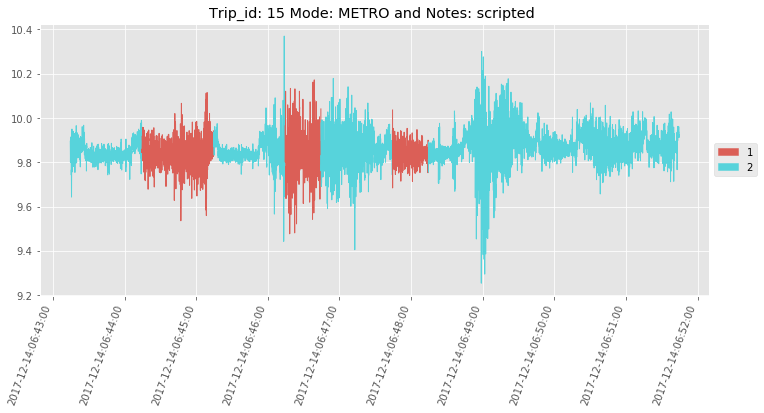

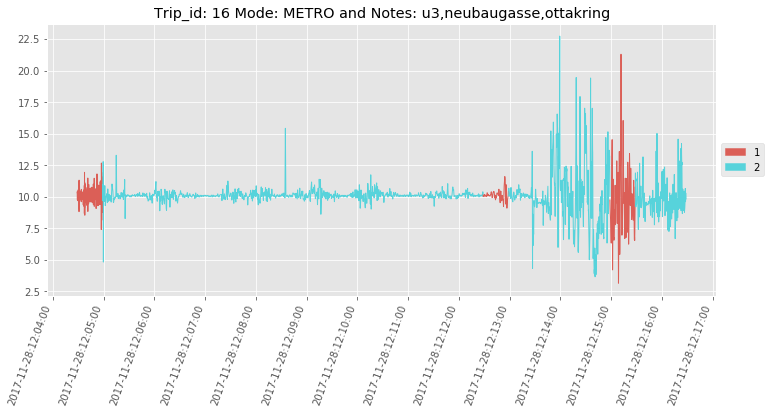

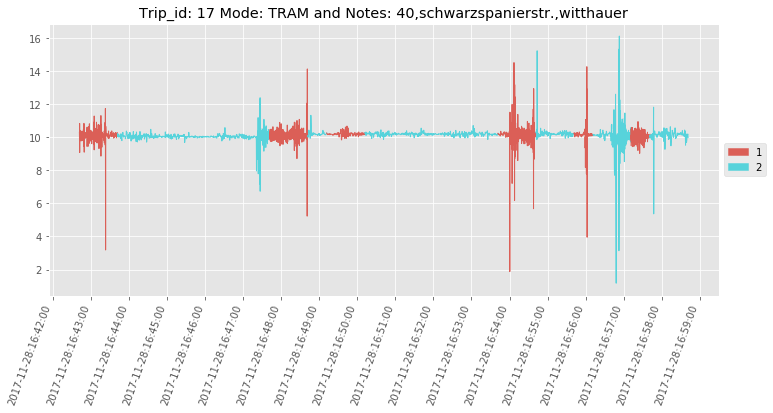

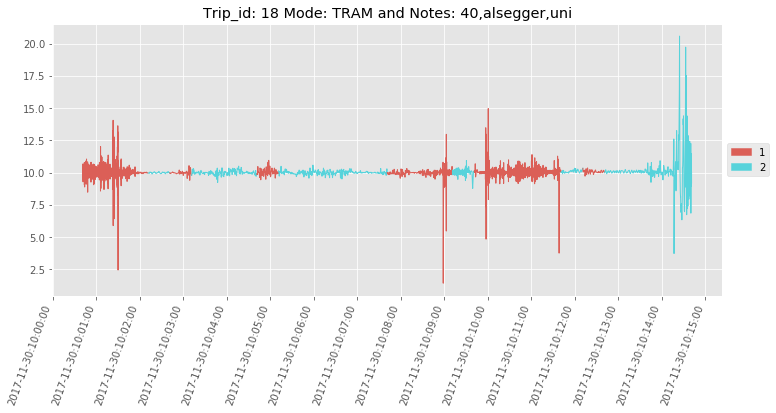

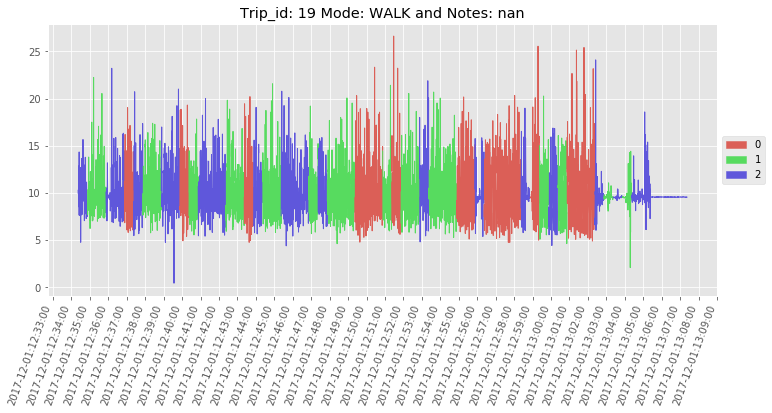

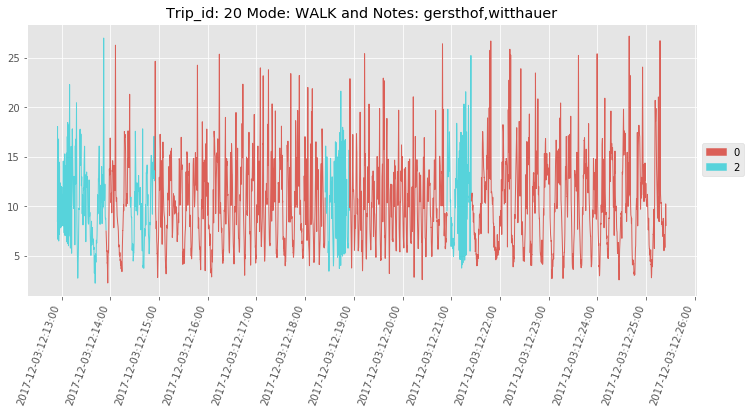

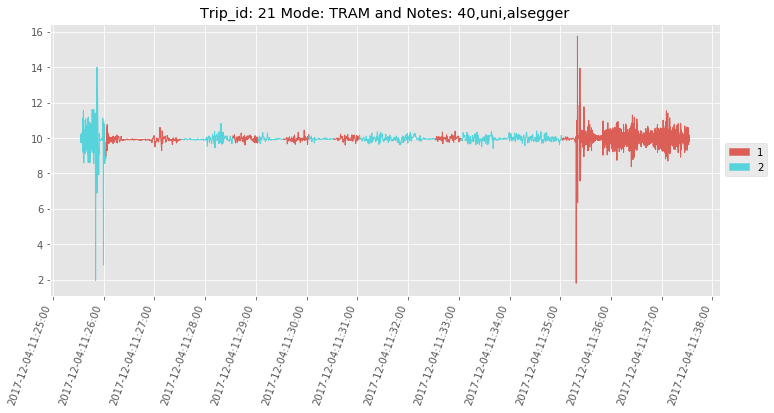

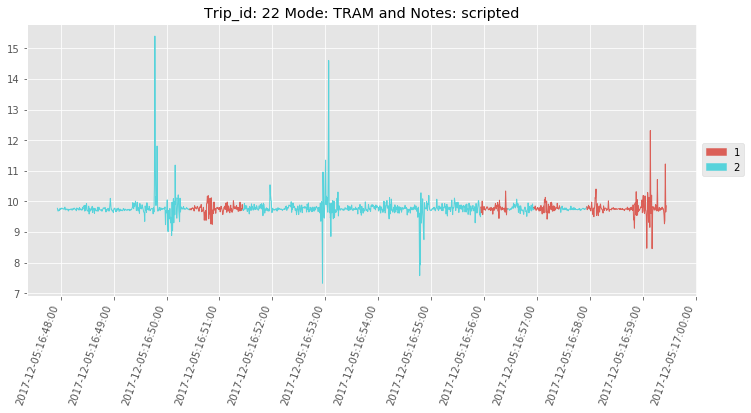

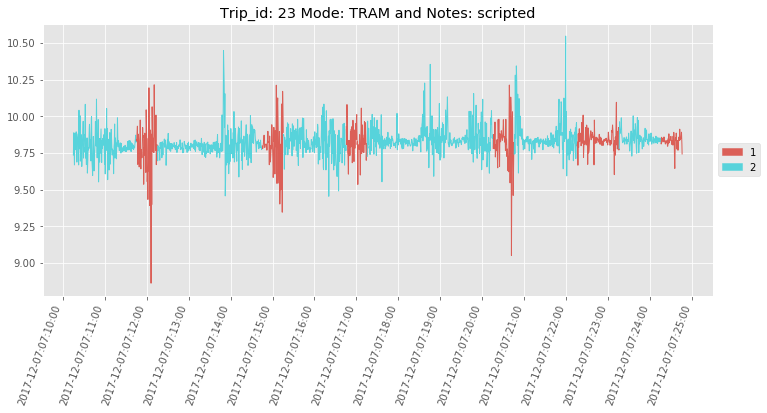

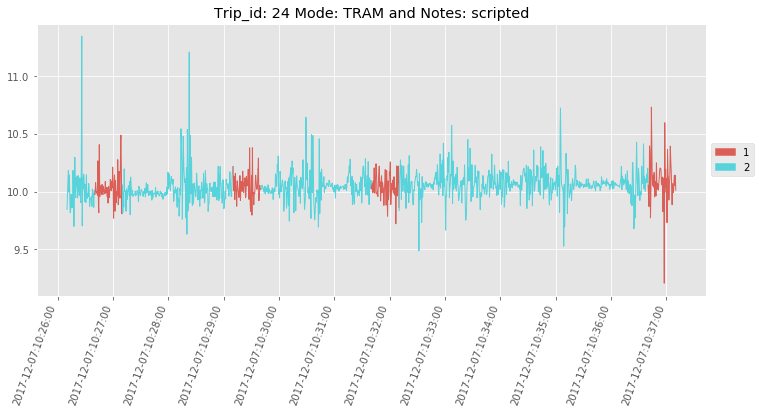

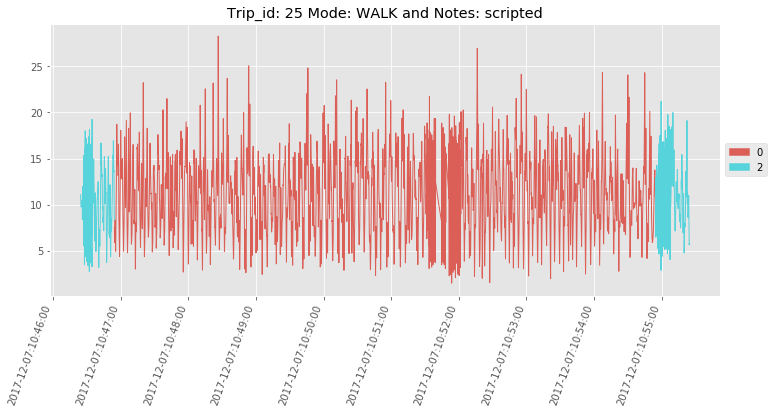

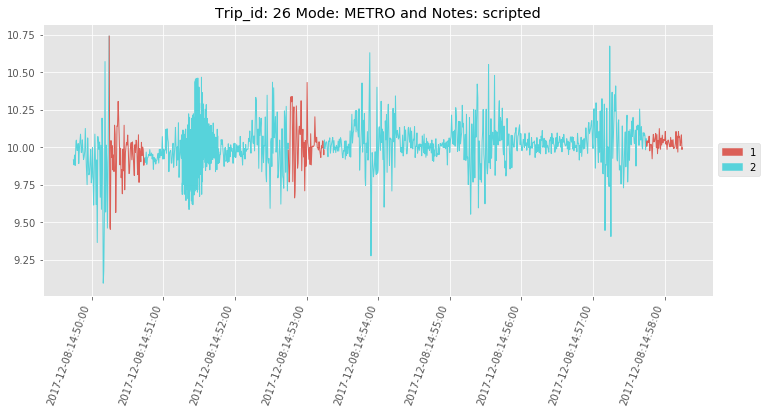

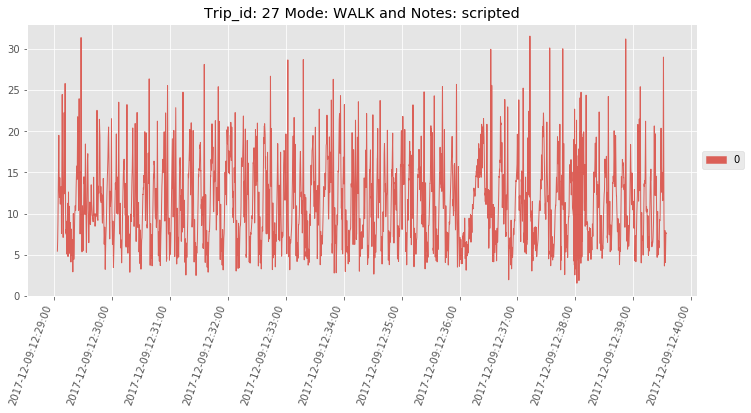

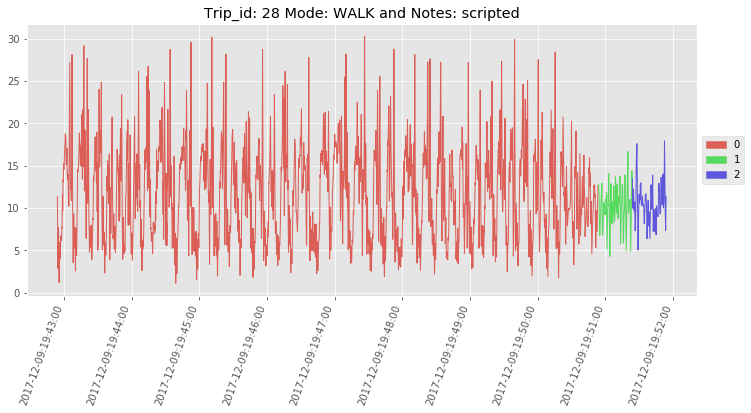

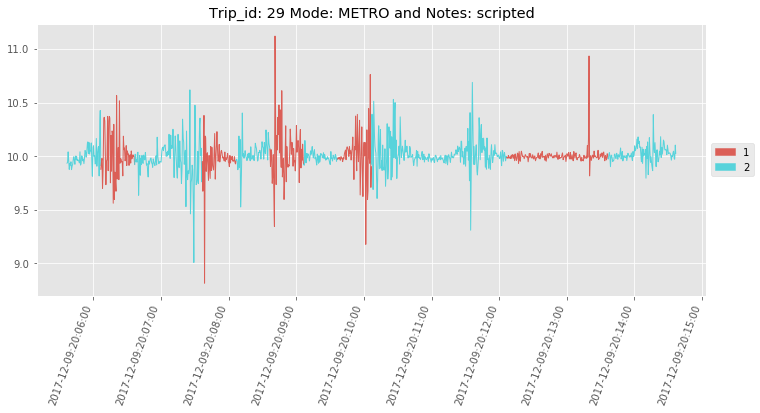

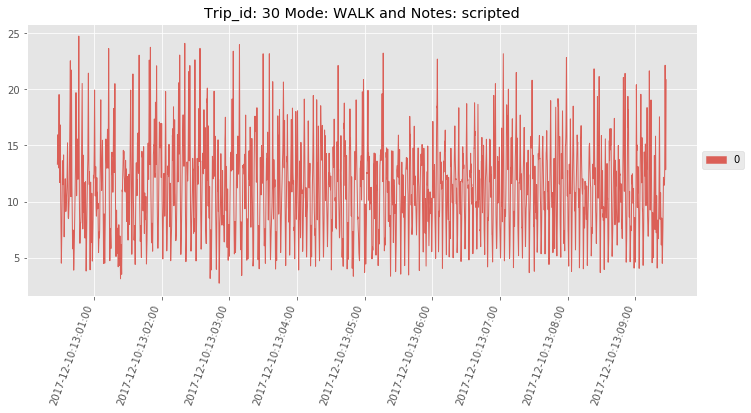

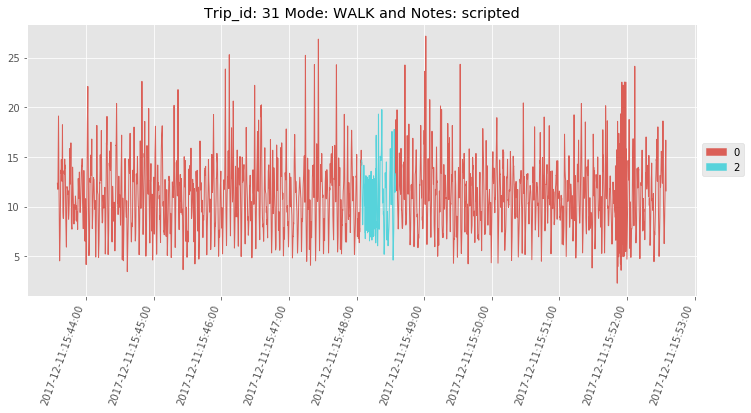

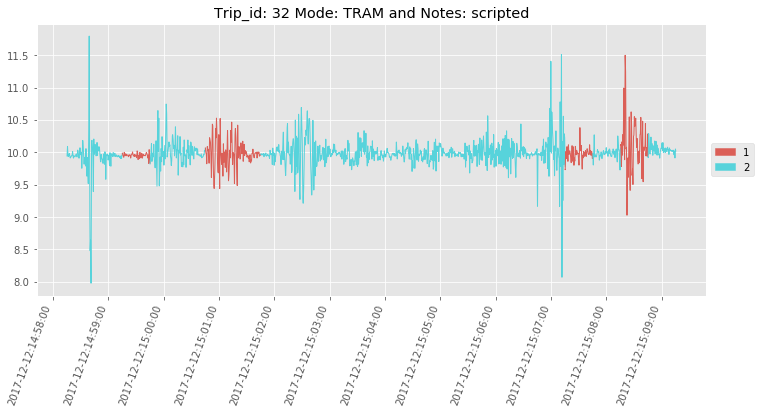

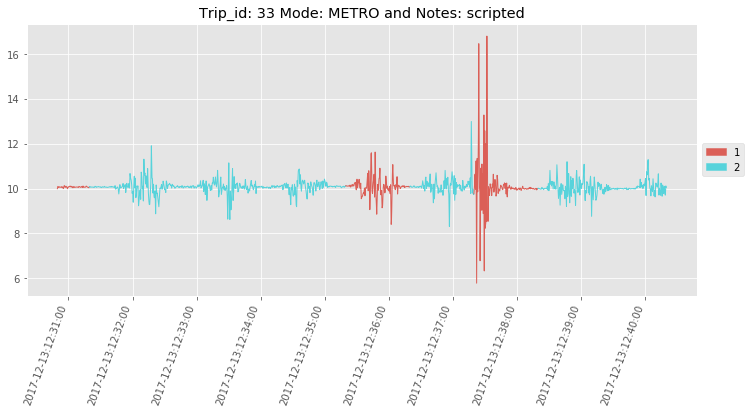

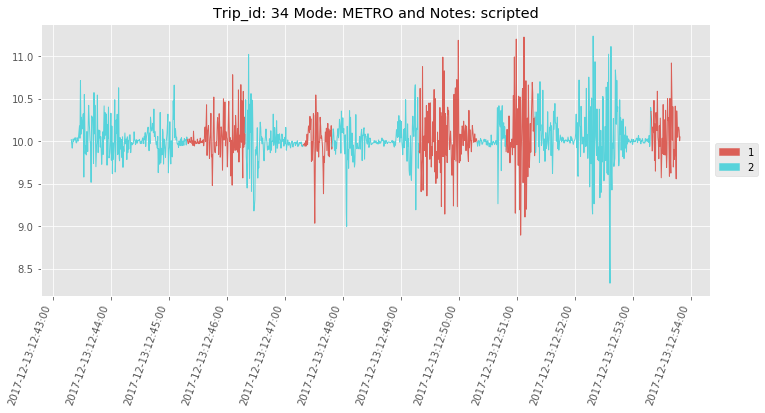

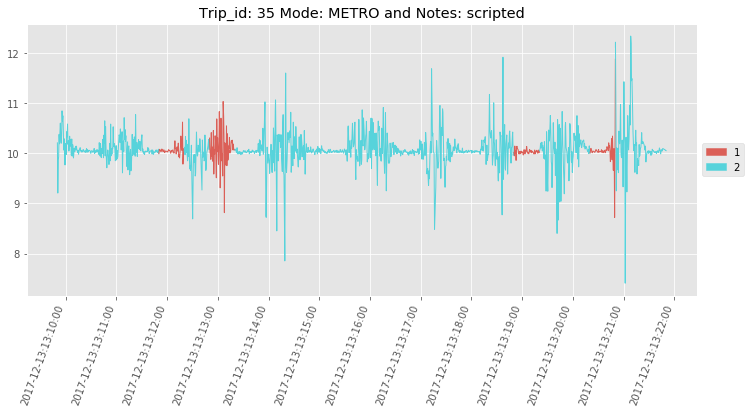

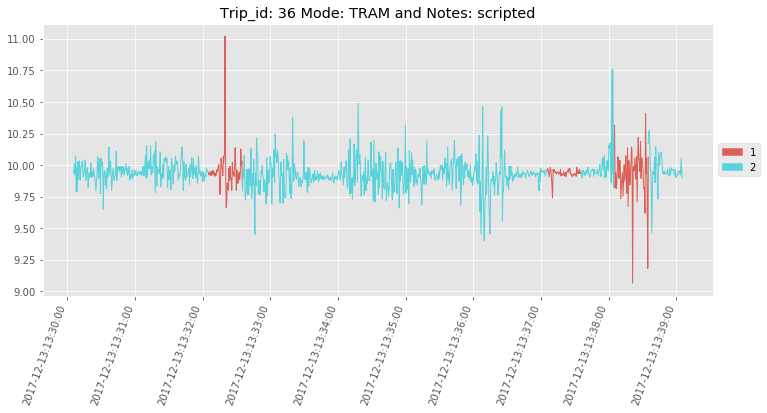

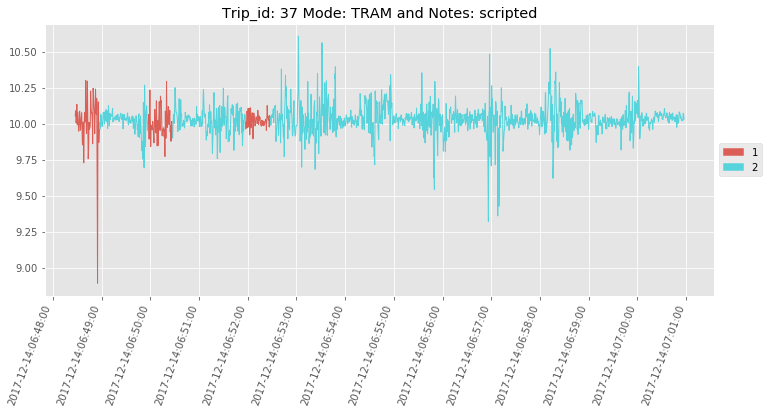

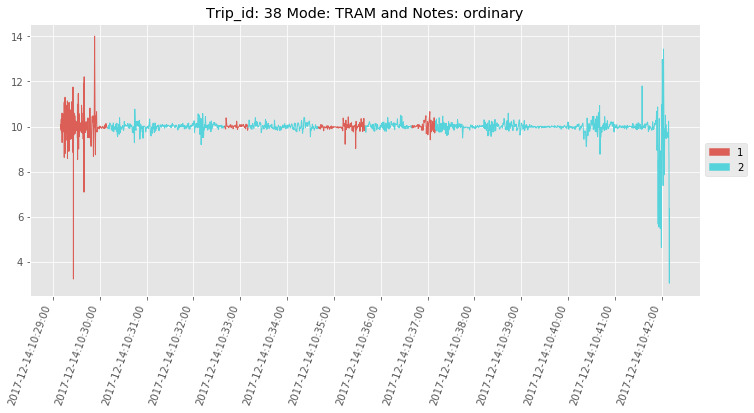

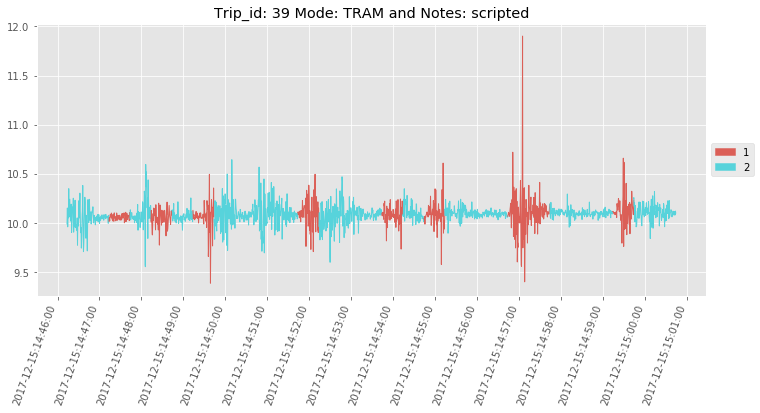

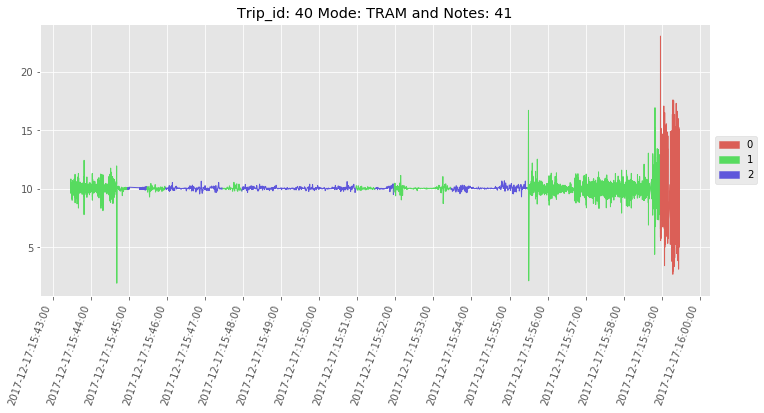

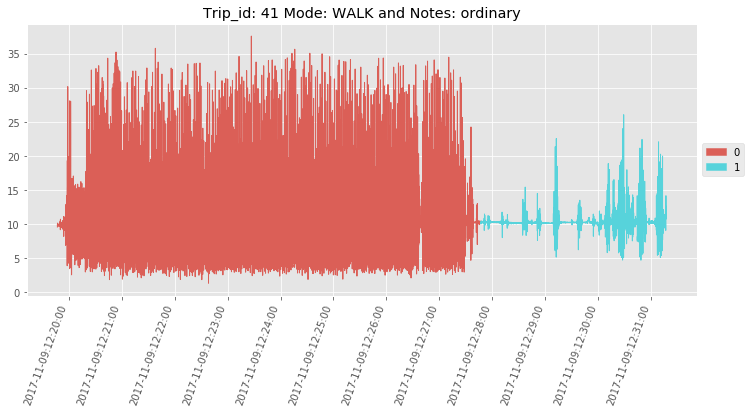

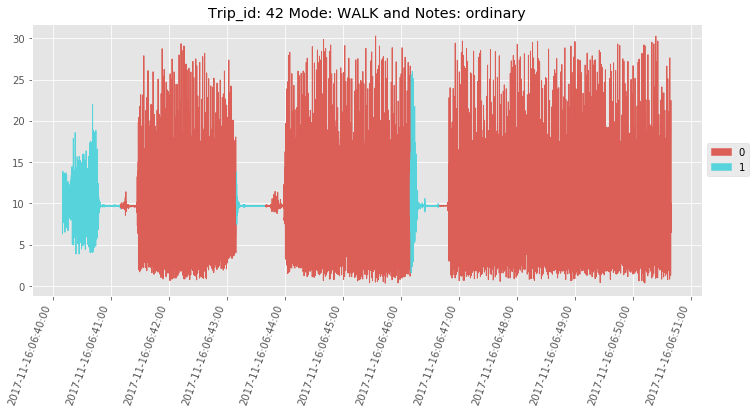

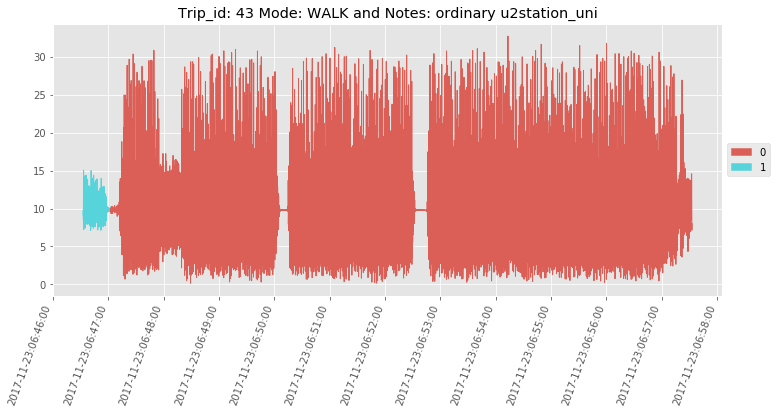

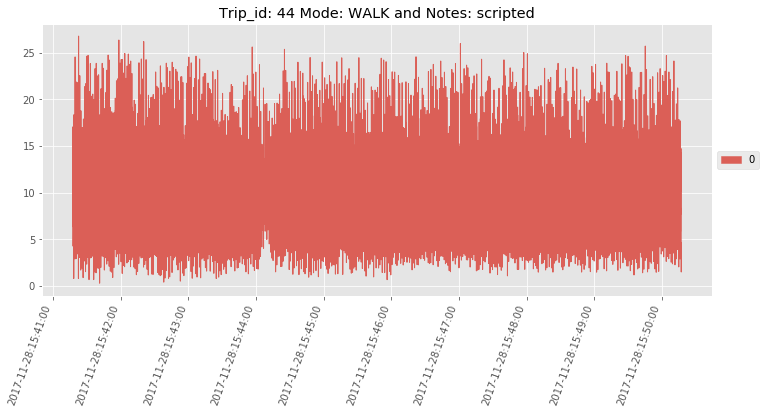

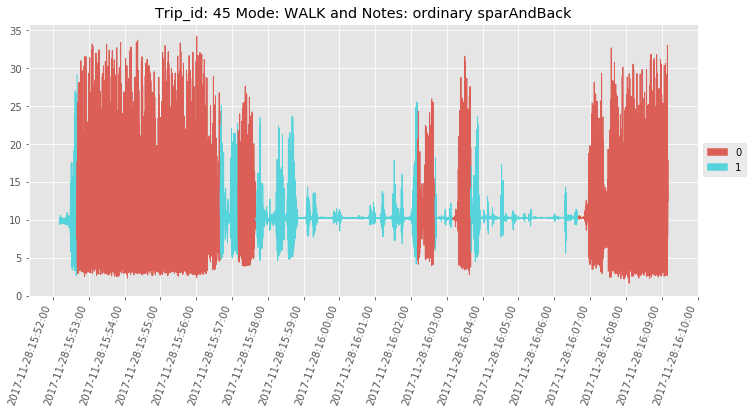

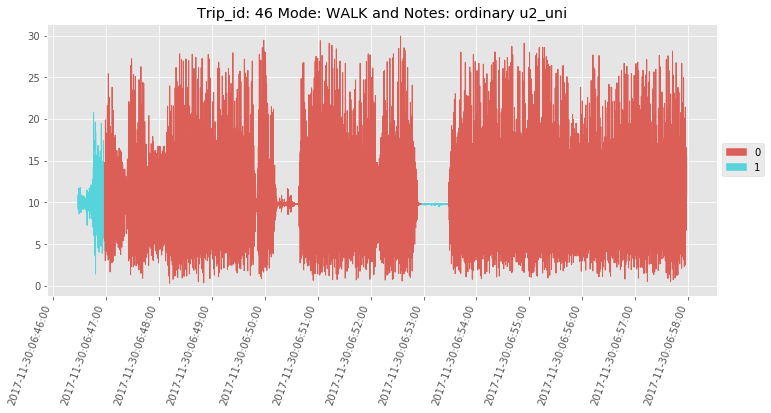

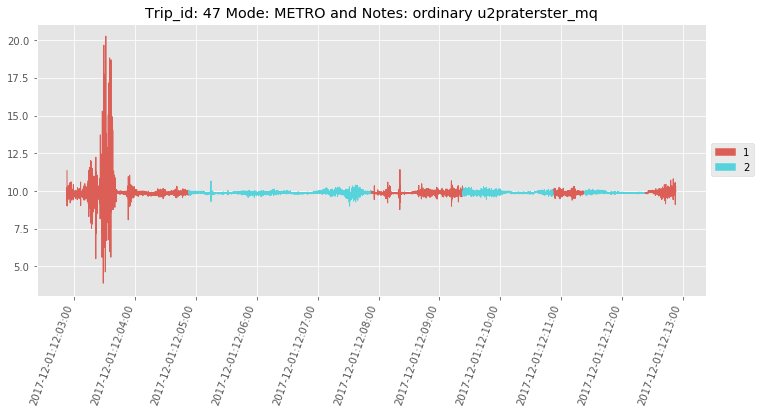

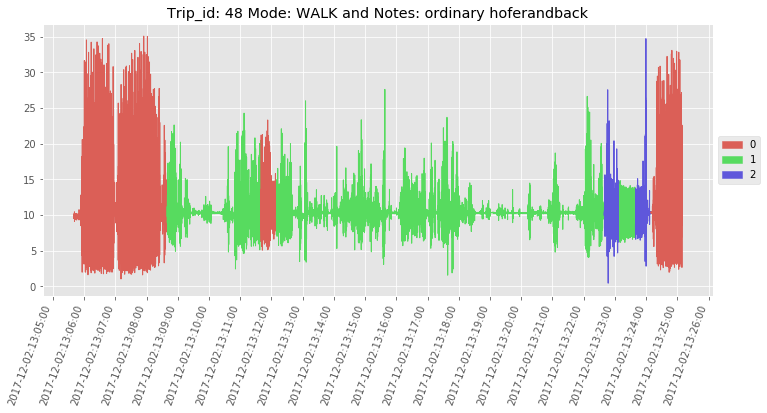

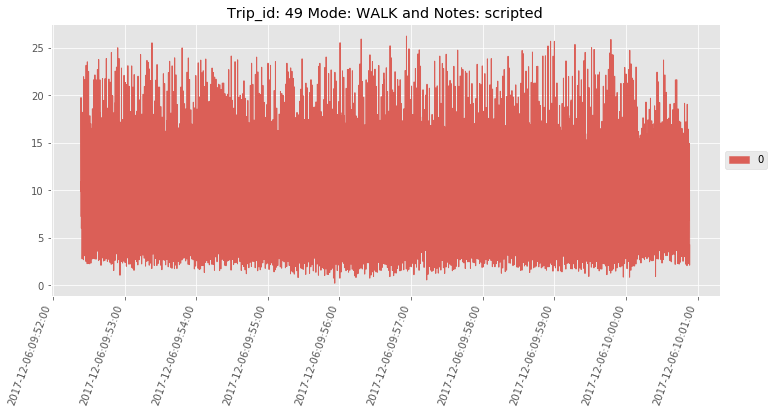

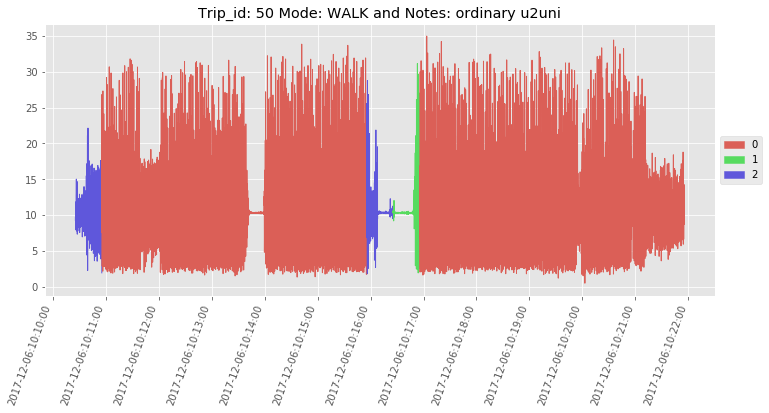

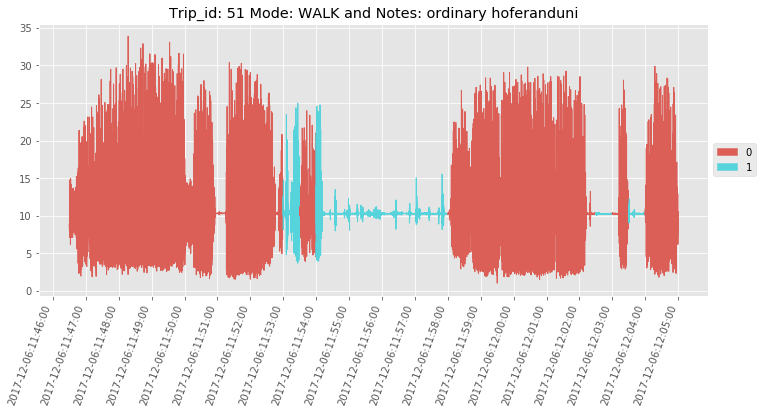

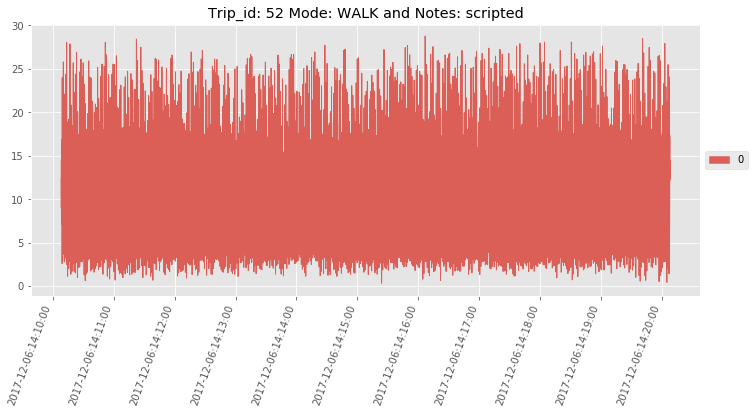

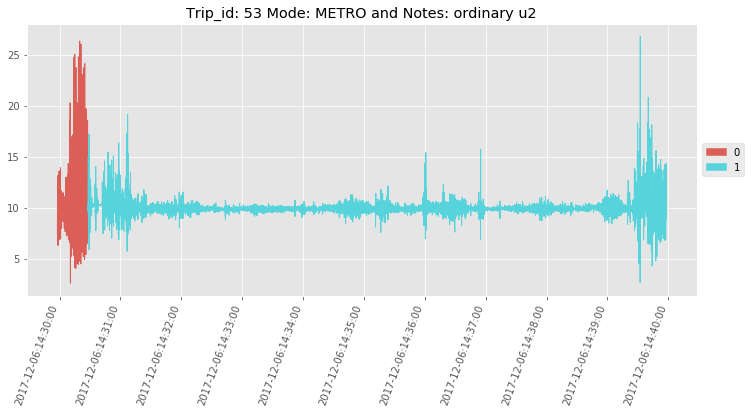

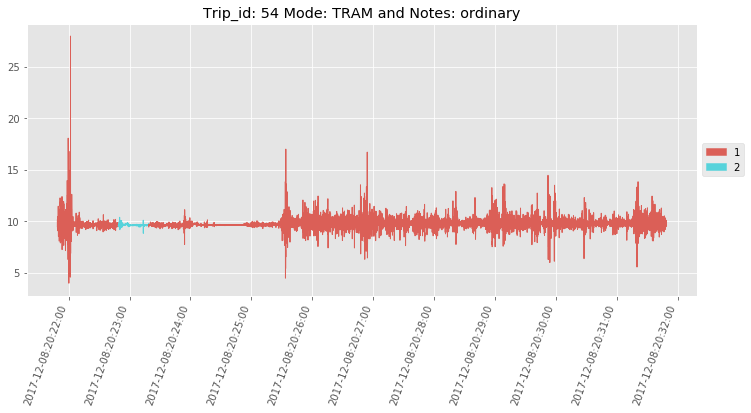

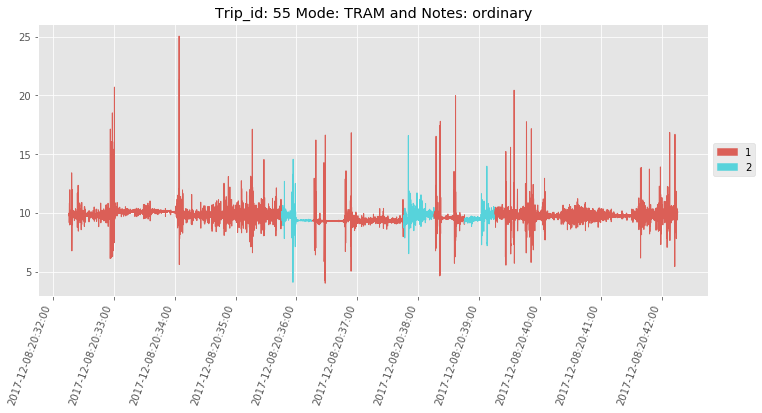

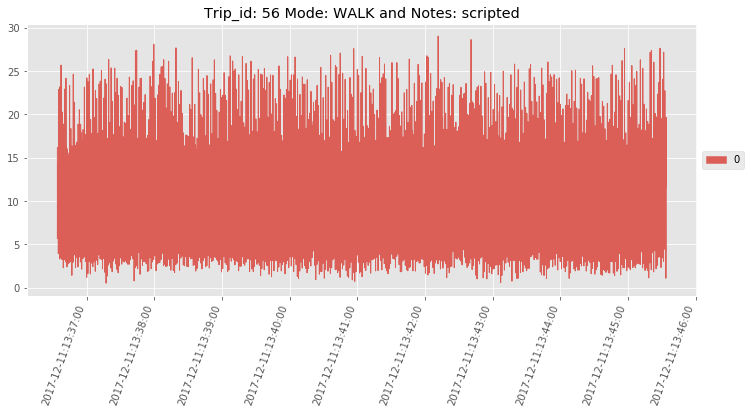

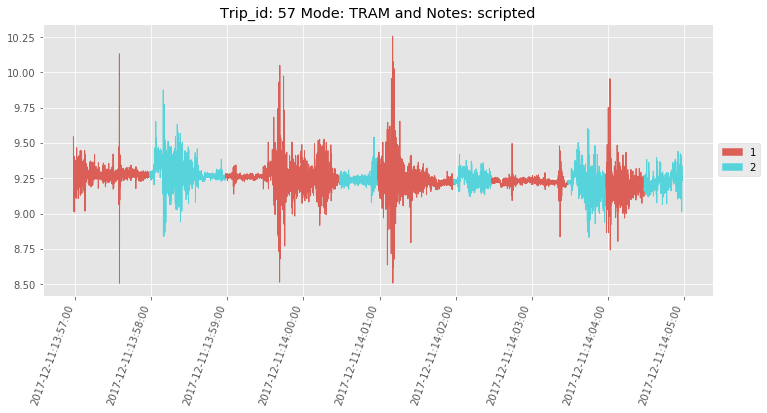

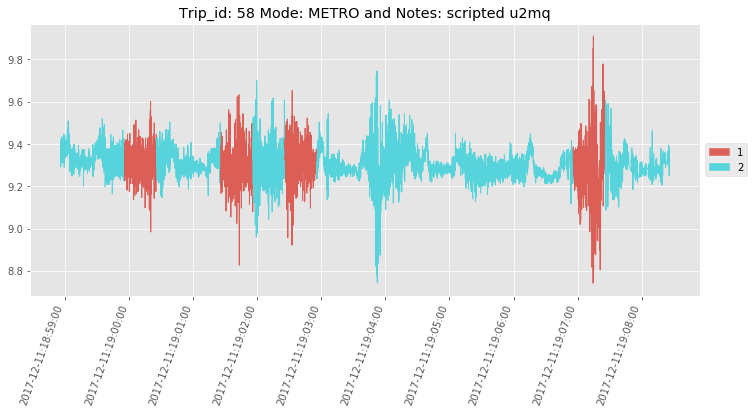

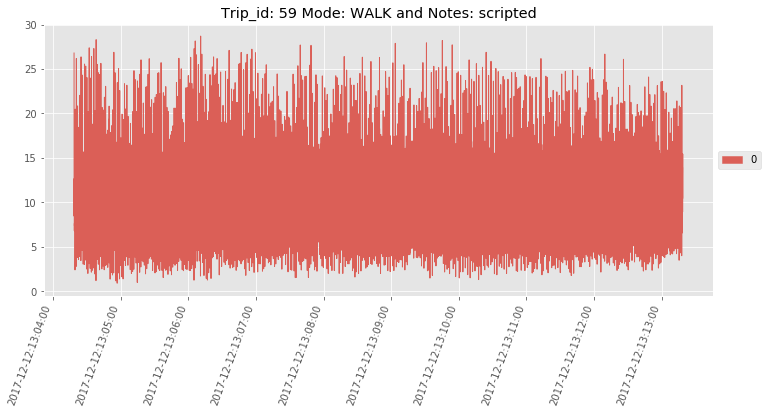

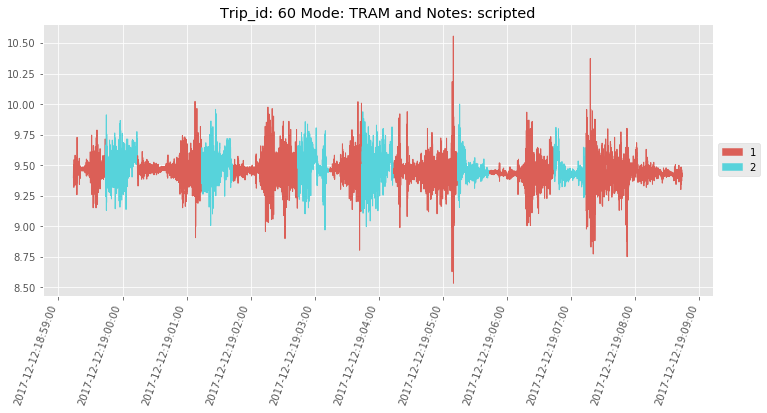

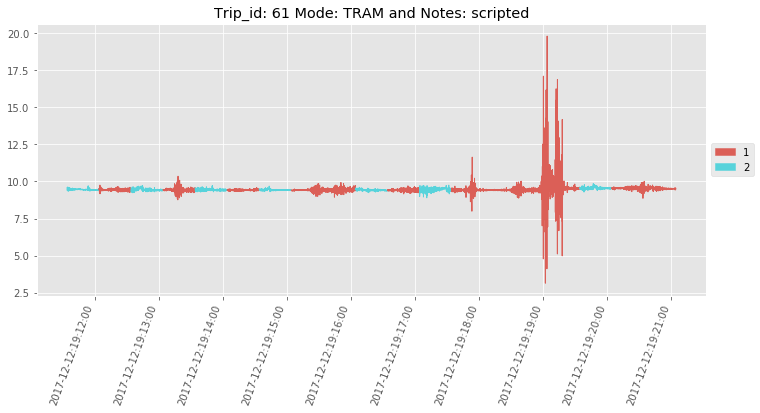

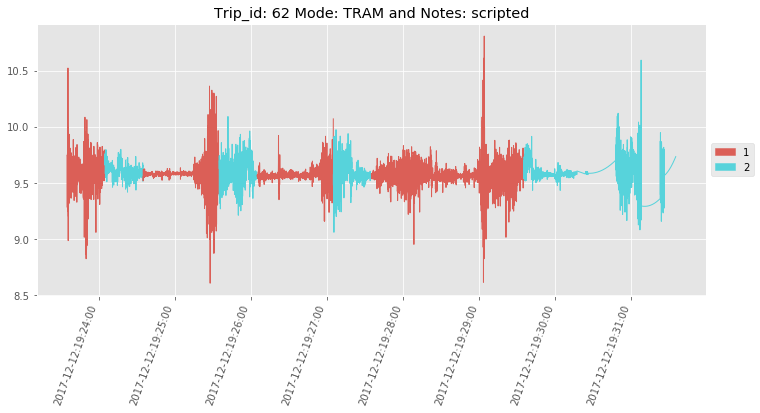

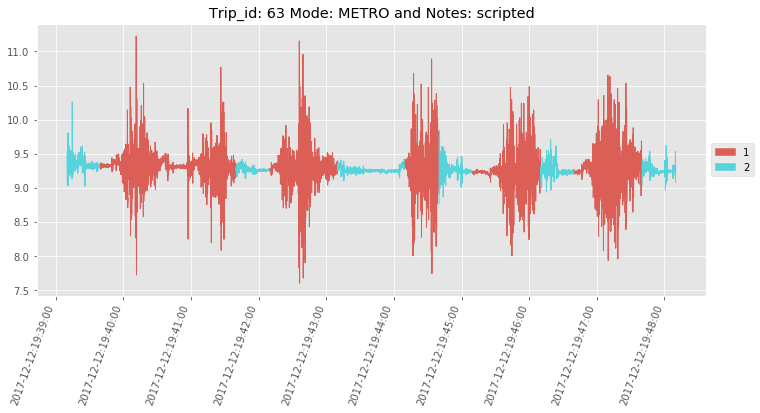

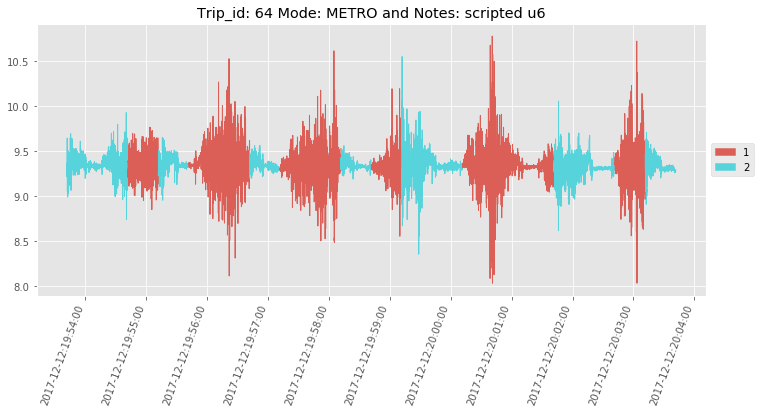

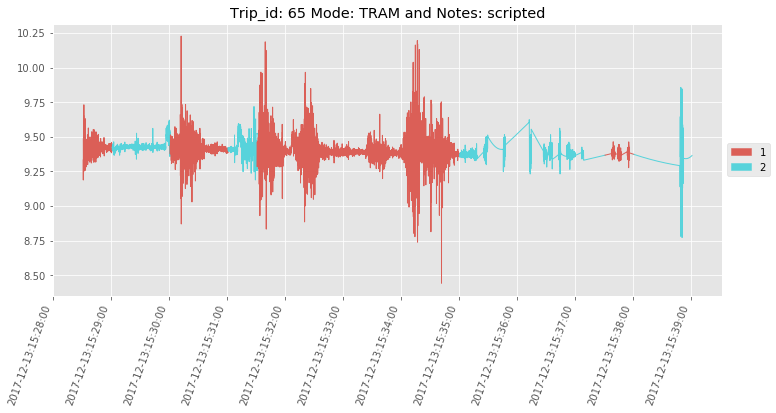

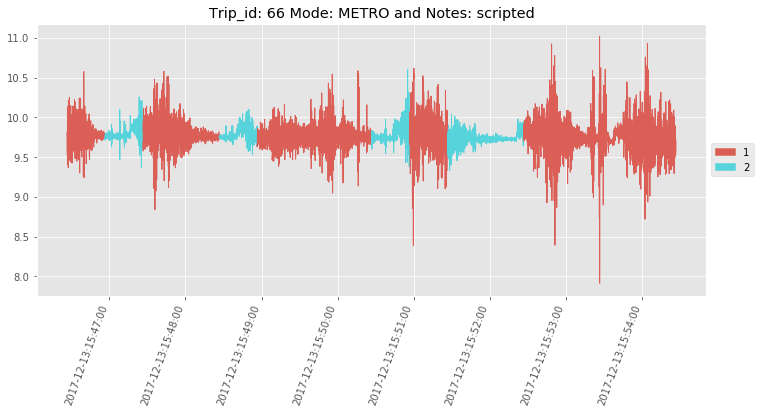

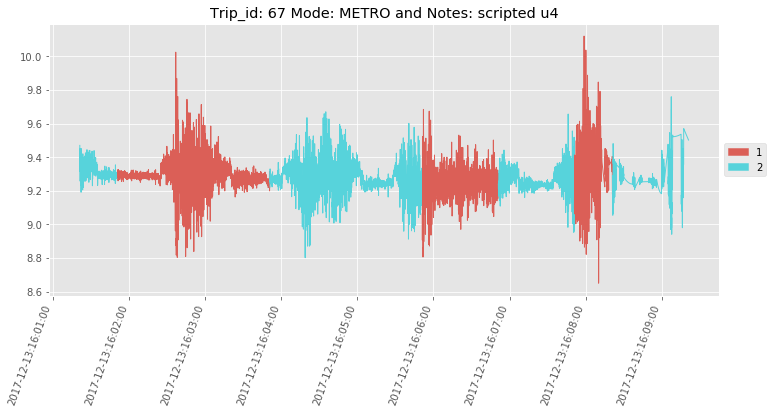

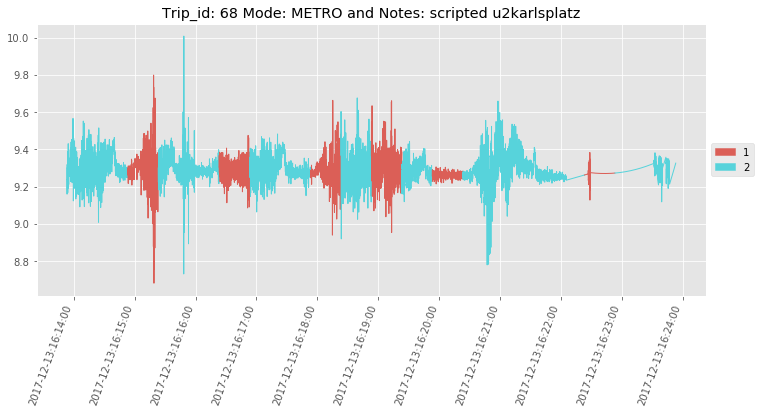

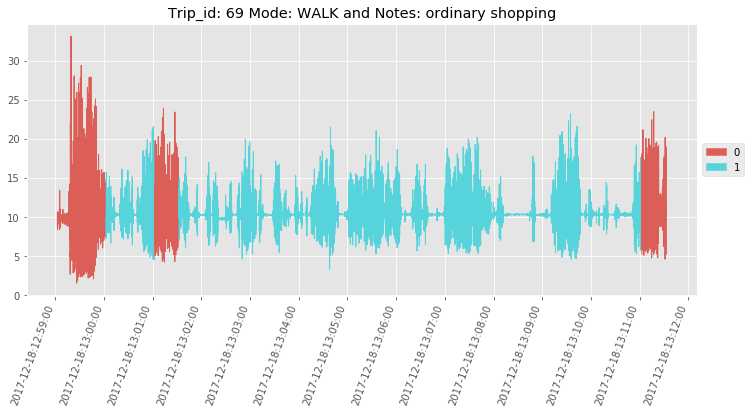

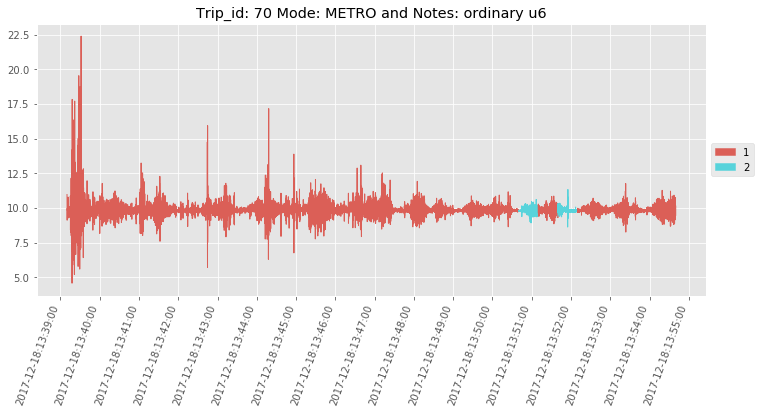

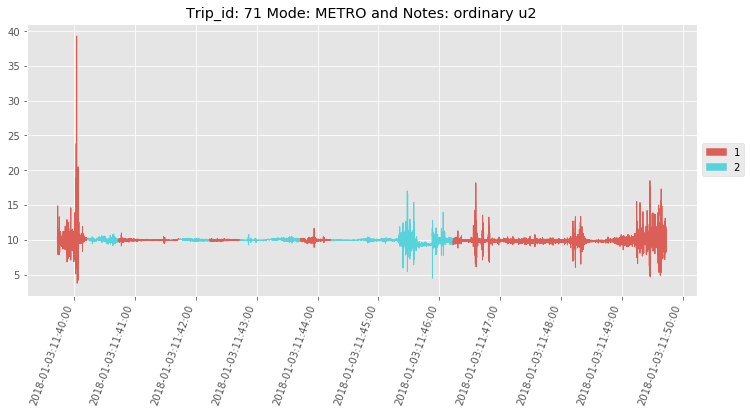

In [39]:

trip_ids = [i for i in euclidean_distances.trip_id.unique()]

for trip_id in trip_ids:
    time, total, labels = \
        get_plot_timeseries_clustering_variables(euclidean_distances,
                                                 trips_unpacked, 
                                                 trip_id, 
                                                 sensor_type="acceleration")


    mode = trips_unpacked[trip_id]["annotation"]["mode"][0]
    notes = trips_unpacked[trip_id]["annotation"]["notes"][0]

    title_format = "Trip_id: {} Mode: {} and Notes: {}"

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title(title_format.format(trip_id,mode,notes))
    plot_timeseries_clustering(time,total, labels, ax=ax)